In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import os
import json
import pickle

import tkinter as tk
import pandas as pd
import cv2
import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

# 0.Dataset/Corresponding labels/Classifier

In [2]:
"""
0.0 Reading mov of static image 
"""
###
if_rotate=False # Rotate 90 if needed
###
cap = cv2.VideoCapture("workspace_physical/static.mov")
frame_list=[]
while(cap.isOpened()):
    ret, frame = cap.read()
    
    if ret == True:
        if if_rotate:
            frame=cv2.rotate(frame, cv2.ROTATE_90_COUNTERCLOCKWISE)
        frame_list.append(frame)
    else:
        break
cap.release()

True

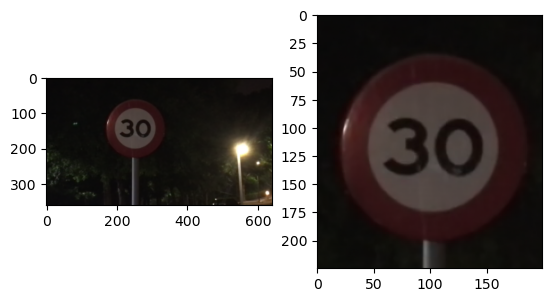

In [3]:
"""
0.1 Select bound for more quality result.
and store victim image 
"""
###
x_bound=(25,250)
y_bound=(150,350)
###

static_img=np.mean(frame_list,axis=0) # mean of multi frames to reduce noise
static_img=np.round(static_img)/255
plt.subplot(1,2,1)
plt.imshow(static_img[:,:,::-1])
plt.subplot(1,2,2)
plt.imshow(static_img[x_bound[0]:x_bound[1],y_bound[0]:y_bound[1]][:,:,::-1])

test_img=static_img[x_bound[0]:x_bound[1],y_bound[0]:y_bound[1]]
cv2.imwrite('workspace_physical/source.png', (test_img*255).astype("uint8"))

In [4]:
"""
0.2 Reading dictionary of label
"""
###
DATASET="GTSRB"
###
with open("params.json", "r") as config:
    params = json.load(config)
    CLASS_N = params[DATASET]["class_n"]
    LABELS = params[DATASET]["labels"]
    CLASSIFIER_INPUT_SHAPE=params[DATASET]["classifier_input_shape"]
    device = params["device"]

In [5]:
"""
0.3 Reading model of corresponding classifer 
"""
from model import Net
###
CLASSIFIER_MODEL=Net
CLASSIFIER_PATH="model/GTSRB-CNN-2.pth"
###
print("CUDA Available: ", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:",device)

classifier = CLASSIFIER_MODEL(CLASS_N).to(device)
classifier.load_state_dict(
    # torch.load(f'./model/{"adv_" if adv_model else ""}model_lisa.pth',
    torch.load(CLASSIFIER_PATH)
)
print("Classifier Path =", CLASSIFIER_PATH)

CUDA Available:  True
Device: cuda
Classifier Path = model/GTSRB-CNN-2.pth


(128, 128)


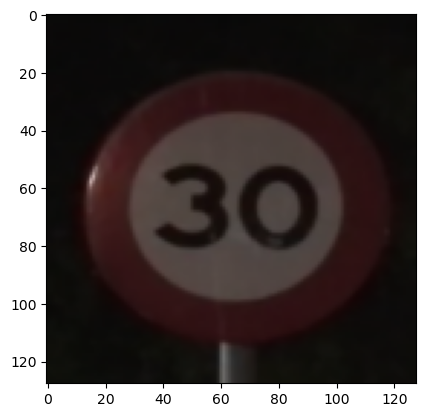

In [6]:
"""
0.4 Read in victim image and corresponding classification 
"""
###
RESIZED_SHAPE=(128,128) # influence the resolution of light generator and ZOO optimizer
###
test_img_ = cv2.imread("workspace_physical/source.png")
test_img = cv2.resize(test_img_, RESIZED_SHAPE, interpolation=cv2.INTER_AREA)
test_img=test_img.astype(np.float32)/255
###
print(test_img[:, :, 0].shape)
plt.imshow(test_img[:, :, ::-1])

c:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\torch\nn\functional.py:4277: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\torch\nn\functional.py:4215: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Predict: 1: Speed limit 30km/h Confidence: 99.38964247703552%
Top 1 (99.39%) = 1: Speed limit 30km/h ...
Top 2 (0.59%) = 5: Speed limit 80km/h ...
Top 3 (0.01%) = 2: Speed limit 50km/h ...
Top 4 (0.01%) = 6: End of speed limit 80k ...
Top 5 (0.00%) = 4: Speed limit 70km/h ...
Top 6 (0.00%) = 3: Speed limit 60km/h ...
Top 7 (0.00%) = 0: Speed limit 20km/h ...
Top 8 (0.00%) = 7: Speed limit 100km/h ...


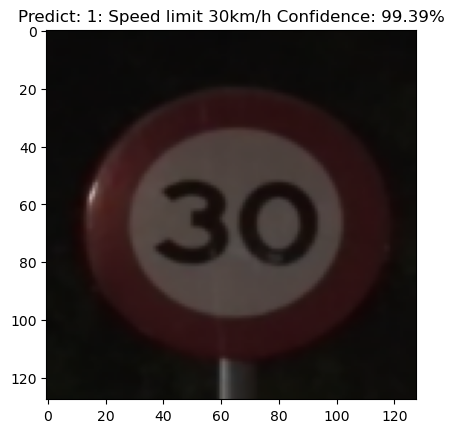

In [7]:
"""
0.5 Prediction of victim classifier and record GROUND TRUTH of victim image 
"""
classifier.eval()
resize_img = cv2.resize(test_img, CLASSIFIER_INPUT_SHAPE, interpolation=cv2.INTER_CUBIC)
tensor_img = torchvision.transforms.ToTensor()(resize_img).to(device)
tensor_img = tensor_img.unsqueeze(0)

predict = torch.softmax(classifier.forward(tensor_img).squeeze(), dim=-1)

index = torch.argmax(predict).item()
confidence = predict[index].item()

###
GROUND_TRUTH = torch.tensor(index).unsqueeze(0)# assumn originally predicted correct
###

print(f"Predict: {LABELS[index]} Confidence: {confidence*100}%")
plt.imshow(test_img[:, :, ::-1])
plt.title("Predict: {} Confidence: {:.2f}%".format(LABELS[index],confidence*100))

probs, indices = torch.topk(predict, k=8)
probs = probs.tolist()
indices = indices.tolist()

for i, (indice, p) in enumerate(zip(indices, probs), 1):
    label = LABELS[indice]
    print("Top {} ({:.2f}%) = {}".format(i, p * 100, label[:25]), '...')


# 1.Mask Drawer

In [8]:
"""
1.1 reading target video with lights on victim object
"""
###
SHAPE_RESIZED=(128,128) # influence the resolution of generator and ZOO optimizer
PATH_source="workspace_physical/source.png"
###
source_img = cv2.imread(PATH_source)
source_img = cv2.resize(source_img, SHAPE_RESIZED, interpolation=cv2.INTER_CUBIC)
test_img = source_img.astype(np.float32)/255.0

In [9]:
"""
1.2 record all training target: target_0.mov, target_1.mov ....
"""
import re
target_nums=0
for filename in os.listdir("workspace_physical"):
    pattern_num=re.compile("target_")
    find = re.search(pattern_num, filename)
    if find !=None:
        target_nums+=1
    
print(target_nums)

2


(591, 128, 128, 4)
(591, 128, 128, 3)
(567, 128, 128, 4)
(567, 128, 128, 3)


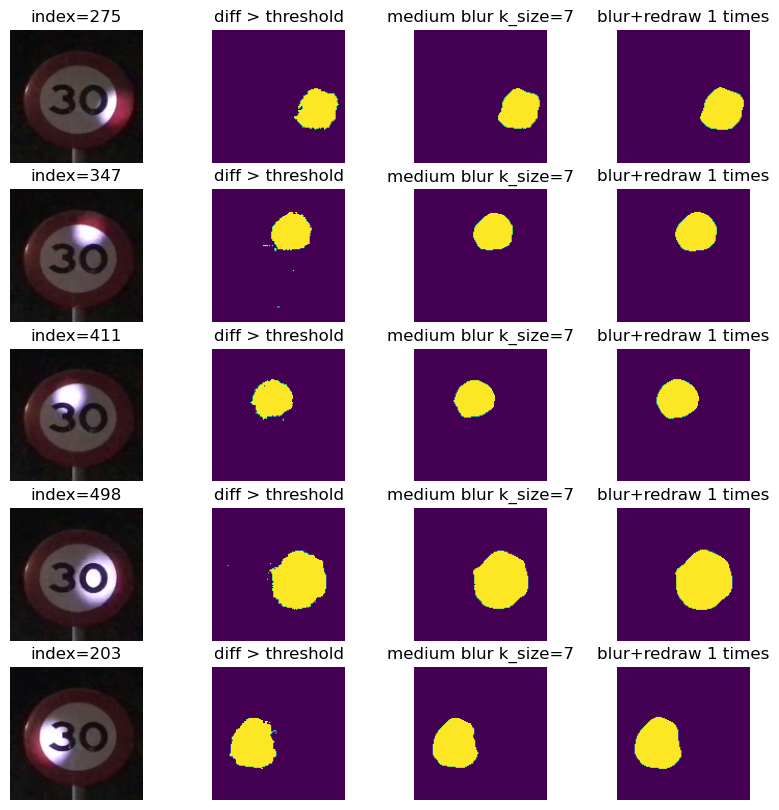

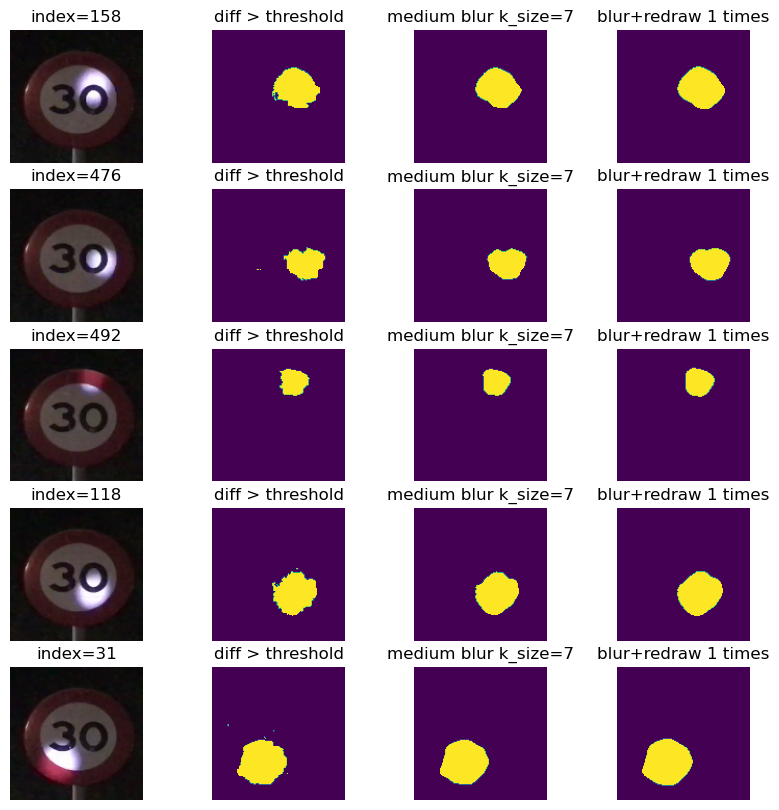

In [10]:
from mask import mask_extract,mask_save,mask_demo
mask_extract(source_img, target_nums, if_rotate,x_bound, y_bound)

In [11]:
"""
1.5 If you satisfy the mask result then concate all existing sub-data you want to train together
"""
mask_save()

Total target(Train) shape= (1158, 128, 128, 3)
Total target( Val ) shape= (127, 128, 128, 3)


# 2. Object-Dependent Light Generator

In [9]:
"""
2.1 Initialize Light Generator 
"""
from model import Generator
###
GENERATOR_MODEL=Generator
GENERATOR_INIT="model/pre_light_generator.pt" # From pre-train stage
###
print("CUDA Available: ", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:",device)

light_generator = GENERATOR_MODEL(gen_input_nc=4, image_nc=3).to(device) # 4 = static+mask
if (GENERATOR_INIT):
    light_generator.load_state_dict(torch.load(GENERATOR_INIT)["model_state_dict"])

CUDA Available:  True
Device: cuda


In [13]:
"""
2.2 Dataset for training Light Generator 
"""
from light_generator import GAN_dataset
###
PATH_traindata="dataset/physical/train_data.npy"
PATH_traintarget="dataset/physical/train_target.npy"
PATH_valdata="dataset/physical/val_data.npy"
PATH_valtarget="dataset/physical/val_target.npy"
batch_size=16
###
load_augmentation=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
               #torchvision.transforms.RandomRotation(degrees=(-30,30))
                                                 ])   
load_transform = torchvision.transforms.ToTensor()

train_dataset = GAN_dataset(PATH_traindata,PATH_traintarget,load_augmentation)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_dataset =  GAN_dataset(PATH_valdata,PATH_valtarget,load_transform)
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=batch_size,shuffle=True)

In [14]:
"""
2.3 Learning Module of Light Generator
"""
G_criterion = nn.MSELoss()

lr_G = 0.0002
beta1 = 0.5 # Beta1 hyperparam for Adam optimizers

optimizerG = optim.Adam(light_generator.parameters(), lr = lr_G, betas=(beta1, 0.999))
schedulerG = torch.optim.lr_scheduler.StepLR(optimizerG, 100, gamma=0.5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch = 0, G_loss_MSE = 0.00126


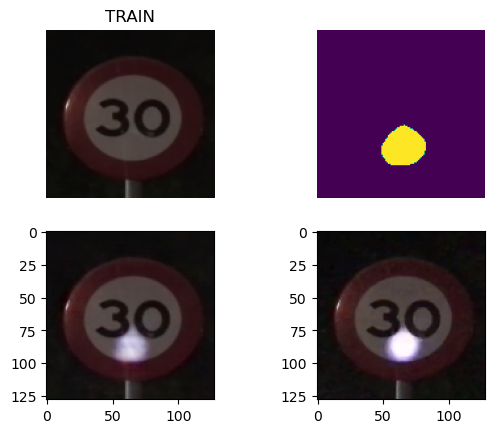

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


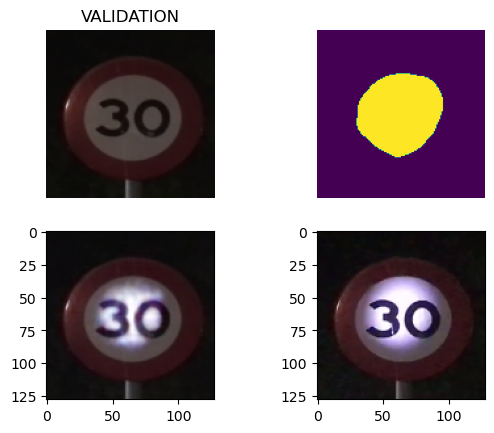

#Validation, G_loss = 0.00194#


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch = 5, G_loss_MSE = 0.00059


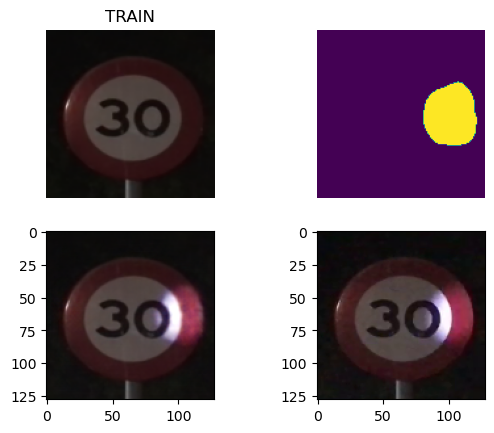

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


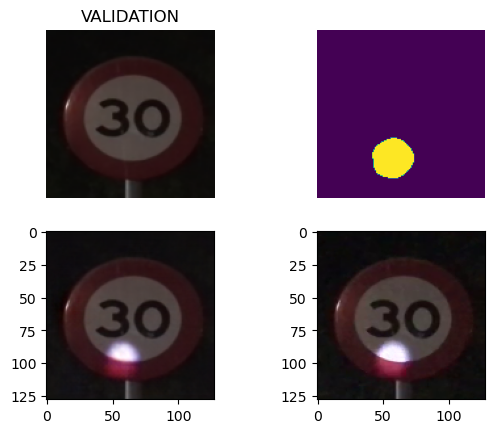

#Validation, G_loss = 0.00070#
epoch = 10, G_loss_MSE = 0.00044


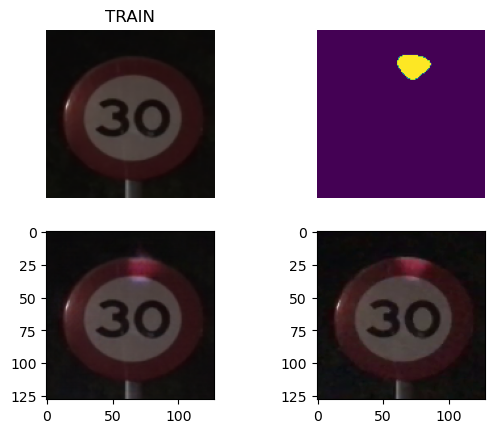

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


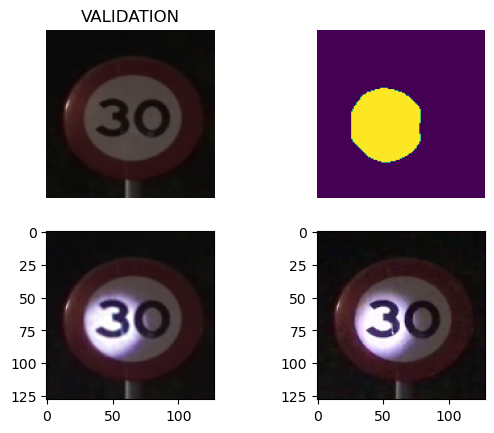

#Validation, G_loss = 0.00048#


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch = 15, G_loss_MSE = 0.00027


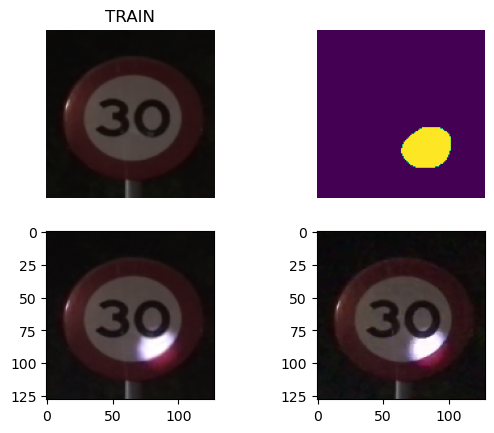

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


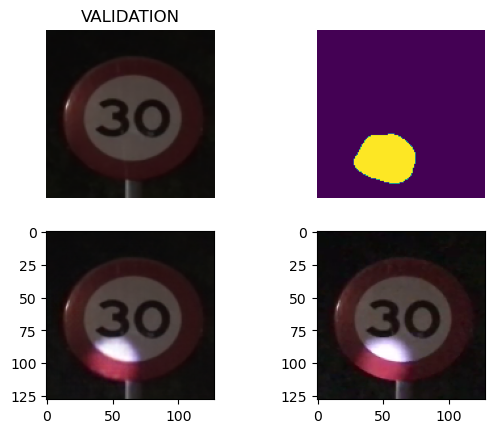

#Validation, G_loss = 0.00039#


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch = 20, G_loss_MSE = 0.00029


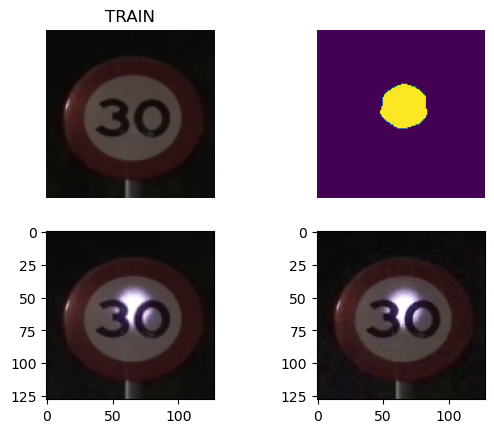

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


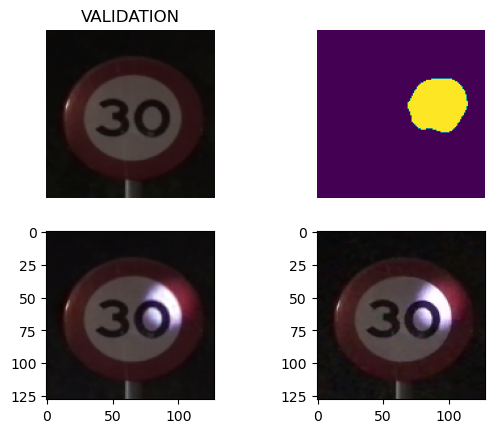

#Validation, G_loss = 0.00043#


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch = 25, G_loss_MSE = 0.00029


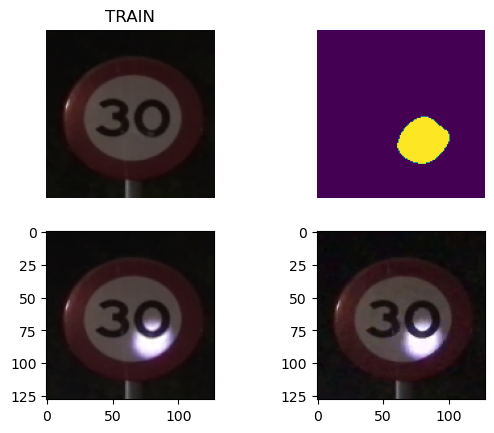

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


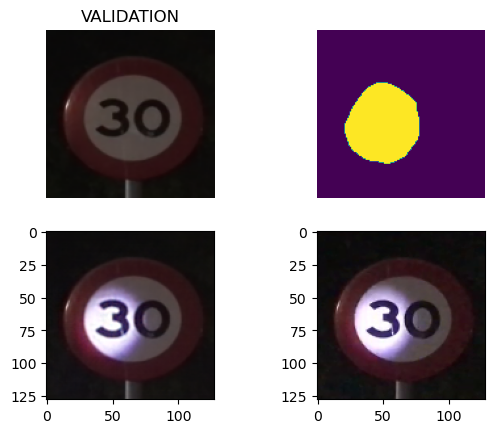

#Validation, G_loss = 0.00034#


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch = 30, G_loss_MSE = 0.00029


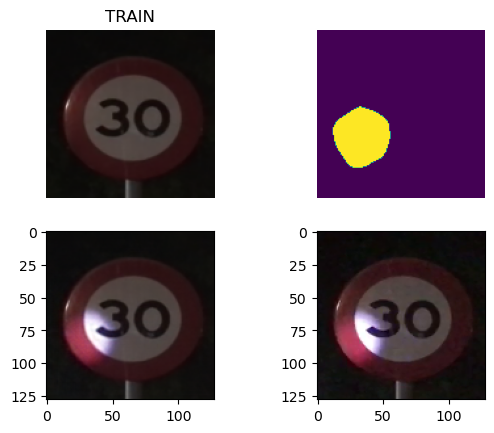

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


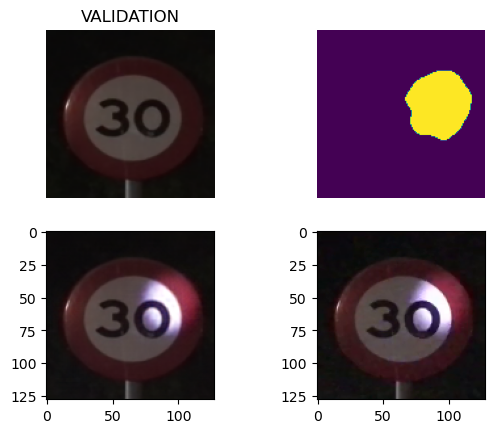

#Validation, G_loss = 0.00037#


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch = 35, G_loss_MSE = 0.00047


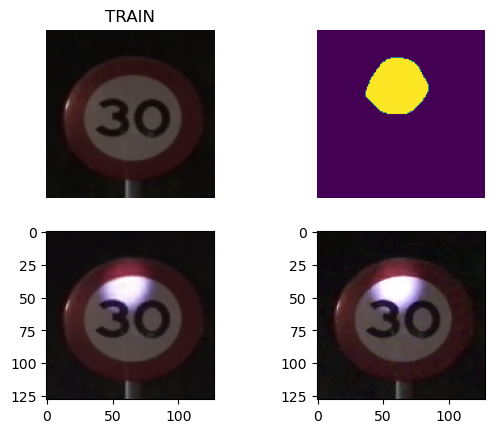

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


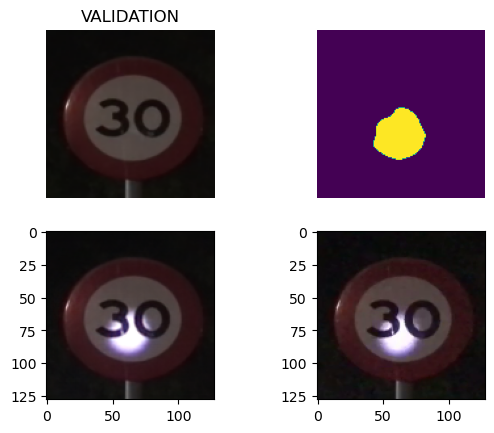

#Validation, G_loss = 0.00090#


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch = 40, G_loss_MSE = 0.00023


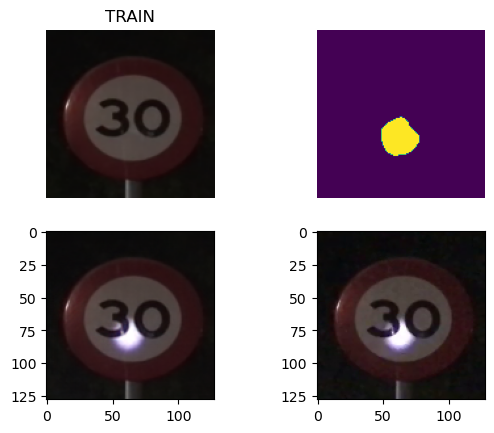

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


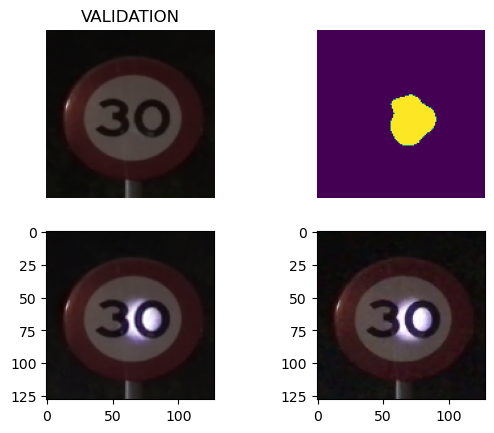

#Validation, G_loss = 0.00034#


In [15]:
from light_generator import train

train(light_generator,optimizerG,schedulerG,G_criterion,train_loader,val_loader,num_epochs=41,Freq_print=5,Freq_plot=5)

[59, 55, 22]


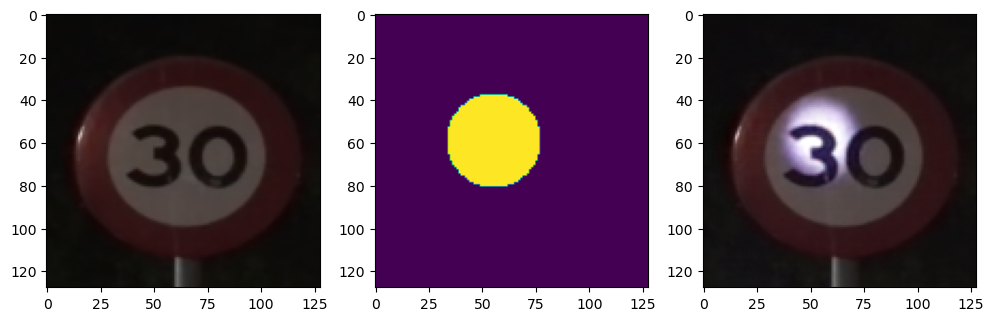

In [10]:
"""
2.5 Demo Light Generator with Random mask
"""
from light_generator import simulate_light_circle,simulate_light_elipse,simulate_light_polygon
###
min_list=[40,40,10] # (x,y,r)
max_list=[80,80,25]
mask_pos=[np.random.randint(min_list[i], max_list[i]) for i in range(len(min_list))]
print(mask_pos)
###


light_generator=GENERATOR_MODEL(gen_input_nc=4, image_nc=3).to(device)
light_generator.load_state_dict(torch.load("model/light_generator.pt")["model_state_dict"])
sim,mask=simulate_light_circle(light_generator, source_img, mask_pos)

plt.figure(figsize=(12,12))
plt.subplot(1,3,1)
plt.imshow(source_img[:,:,::-1])

plt.subplot(1,3,2)
plt.imshow(mask)

plt.subplot(1,3,3)
plt.imshow(sim[:,:,::-1])

In [23]:
print(source_img)

[[[ 9 10 11]
  [ 9 10 10]
  [ 9 10 10]
  ...
  [ 9 10 10]
  [10 10 10]
  [ 9 10 11]]

 [[10 10 11]
  [ 9 10 11]
  [ 9 10 10]
  ...
  [10 10 11]
  [ 9  9 10]
  [ 9 10 10]]

 [[ 9 11 11]
  [ 9 11 10]
  [ 9 10 10]
  ...
  [10 10 10]
  [ 9 10 10]
  [10 10 10]]

 ...

 [[ 9 14 13]
  [10 15 14]
  [10 16 15]
  ...
  [10 12 13]
  [10 12 13]
  [10 13 14]]

 [[10 15 14]
  [ 9 15 14]
  [ 9 14 14]
  ...
  [10 12 14]
  [11 12 14]
  [11 13 14]]

 [[10 15 14]
  [10 14 14]
  [ 9 14 13]
  ...
  [10 13 14]
  [11 13 14]
  [10 13 14]]]


# 3.ZOO attack optimizer

In [14]:
from optimize import ZeroOrderOptimizer

###
test_img
criteria = nn.CrossEntropyLoss()
label_attack = GROUND_TRUTH[0]

#############################################################
pos_min_list=[0.3*RESIZED_SHAPE[0], 0.3*RESIZED_SHAPE[1],30] # specify lower bound of each dimension (x1,y1,x2,y2,x3,y3)
pos_max_list=[0.7*RESIZED_SHAPE[0], 0.7*RESIZED_SHAPE[1],10] # specify upper bound of each dimension
###
ZOO_optimizer = ZeroOrderOptimizer(
    source_img, # victim image
    iter=6, # optimize iter of each start point
    label=GROUND_TRUTH.squeeze(),
    attack_model=classifier,
    light_generator=light_generator,
    criteria=criteria, # score criteria
    point_num=5, # number of start point
    draw_light=simulate_light_circle, # draw mask from pos-space to x,y plabe
    min_list=pos_min_list, # lower bound of pos-space
    max_list=pos_max_list, # upper bound of pos-space
    classifier_input_shape=CLASSIFIER_INPUT_SHAPE,
    LABELS=LABELS,
    grad_step=1, # step size to approximate grad(smoothing parameter in ZOO term)
    lr_step=3, # optimize step based on grad
    threshold_restart=0.001 # converge restart threshold
)

Device =  cuda
0.7831591963768005
4.463054656982422
1.007829189300537
3.2350082397460938
2.0265558760002023e-06
0.1987859010696411
0.043761394917964935
2.422410488128662
4.887569048150908e-06
0.03254115208983421


In [15]:
ZOO_optimizer.run()

converge --> random start
converge --> random start
converge --> random start


2: Speed limit 50km/h
Confidence: 99.87379908561707 %
best pos [75, 52, 10]
Largest Loss 7.449066638946533


False

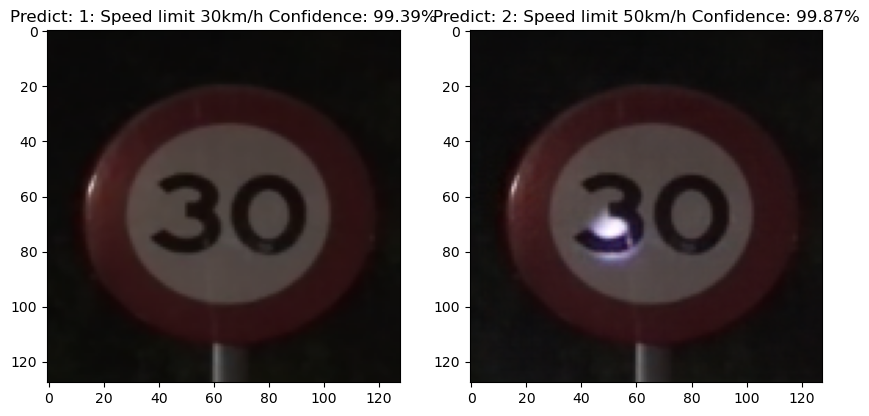

In [16]:
"""
3.5 Demo of ZOO optimize result 
"""
print(LABELS[ZOO_optimizer.predict])
print(f"Confidence: {ZOO_optimizer.confidence.item()*100} %")
print("best pos", ZOO_optimizer.global_best_pos)
print("Largest Loss",ZOO_optimizer.global_best_value)

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.title("Predict: {} Confidence: {:.2f}%".format(LABELS[index],confidence*100))
plt.imshow(test_img[:,:,::-1])

plt.subplot(122)
plt.title("Predict: {} Confidence: {:.2f}%".format(LABELS[ZOO_optimizer.predict], ZOO_optimizer.confidence.item()*100))
plt.imshow(ZOO_optimizer.attack_img[:,:,::-1])

cv2.imwrite('workspace/sim_light.png', (ZOO_optimizer.attack_img*255).clip(0,255).astype("uint8"))

# 4. Into Physical

True

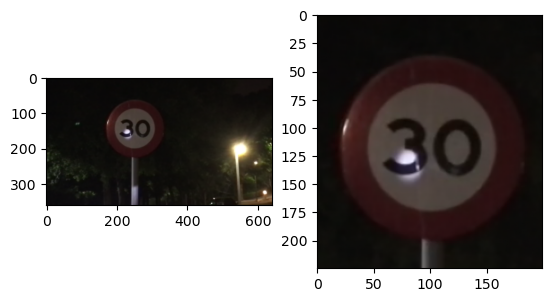

In [18]:
# !!! Due to the run to run variance your result might differ.
"""
4.1 video to image reduce noise(or skip this part use png only) 
"""
cap = cv2.VideoCapture("workspace_physical/physical.mov")
frame_list=[]
while(cap.isOpened()):
    ret, frame = cap.read()
    
    if ret == True:
        if if_rotate:
            frame=cv2.rotate(frame, cv2.ROTATE_90_COUNTERCLOCKWISE)
        frame_list.append(frame)
    else:
        break
cap.release()

static_img=np.mean(frame_list,axis=0) # mean of multi frames to reduce noise
static_img=np.round(static_img)/255
plt.subplot(1,2,1)
plt.imshow(static_img[:,:,::-1])
plt.subplot(1,2,2)
plt.imshow(static_img[x_bound[0]:x_bound[1],y_bound[0]:y_bound[1]][:,:,::-1])

test_img=static_img[x_bound[0]:x_bound[1],y_bound[0]:y_bound[1]]
cv2.imwrite('workspace_physical/physical.png', (test_img*255).astype("uint8"))

Text(0.5, 1.0, '2: Speed limit 50km/h... Confidence: 99.90%')

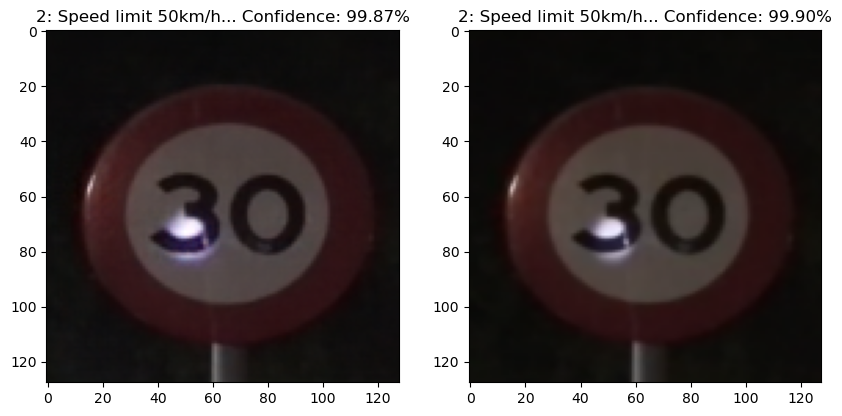

In [22]:
"""
4.2 Inference physical image to evaluate simulation and physical attack 
"""
###
physical_img_ = cv2.imread("workspace_physical/physical.png")
###
physical_img = cv2.resize(physical_img_, RESIZED_SHAPE, interpolation=cv2.INTER_AREA)
physical_img=physical_img.astype(np.float32)/255

classifier.eval()
resize_img = cv2.resize(physical_img, CLASSIFIER_INPUT_SHAPE, interpolation=cv2.INTER_CUBIC)
tensor_img = torchvision.transforms.ToTensor()(resize_img).unsqueeze(0).to(device)

predict_phy = torch.softmax(classifier.forward(tensor_img).squeeze(), dim=-1)

index_phy = torch.argmax(predict_phy).item()
confidence_phy = predict_phy[index_phy].item()

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.title("{}... Confidence: {:.2f}%".format(LABELS[ZOO_optimizer.predict][:25], ZOO_optimizer.confidence.item()*100))
plt.imshow(ZOO_optimizer.attack_img[:,:,::-1])

plt.subplot(122)
plt.imshow(physical_img[:,:,::-1])
plt.title("{}... Confidence: {:.2f}%".format(LABELS[index_phy][:25],confidence_phy*100))